In [2]:
import cv2

import os
from os.path import exists
import pandas as pd
import numpy as np
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
from skimage.segmentation import active_contour
import cv2 as cv
from skimage.segmentation import clear_border
from skimage.filters import try_all_threshold
from skimage.filters import threshold_otsu
from skimage import measure, morphology
from sklearn.metrics import f1_score

# Import packages for image processing
from skimage import morphology, filters #for measuring things in the masks

ImageFile.LOAD_TRUNCATED_IMAGES = True

import csv
import random 

A typical image would be path "..\data\images_resized\PAT_70_107_591.png"

In [58]:
# locate file
file_data = '..' + os.sep + 'data' + os.sep +'metadata.csv'
path_image = '..' + os.sep + 'data' + os.sep + 'images' + os.sep + 'imgs_part_1'

Literature on Gaussian smoothing:
https://medium.com/jun94-devpblog/cv-2-gaussian-and-median-filter-separable-2d-filter-2d11ee022c66

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


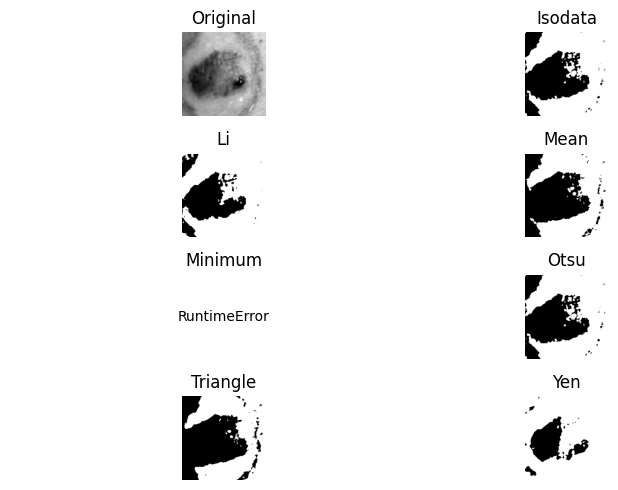

In [59]:
# Load the image
image_path = "..\\data\\images_resized\\PAT_70_107_155.png"
img = cv2.imread(image_path)

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply median filtering to the grayscale image
median_filtered = skimage.filters.median(gray)

# Use try_all_threshold to determine the optimal thresholding method
result = skimage.filters.thresholding.try_all_threshold(median_filtered)

In [60]:
def preprocess_image(image_path):
    # Load the image
    img = cv2.imread(image_path)

    # # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply a Gaussian blur to the grayscale to smooth out any noise
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # Normalize the color channels, scales the pixel values between 0 and 255
    norm = cv2.normalize(blur, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

    # Enhance the contrast of the normalized image using the Contrast Limited Adaptive Histogram Equalization (CLAHE) algorithm
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(norm)

    return enhanced

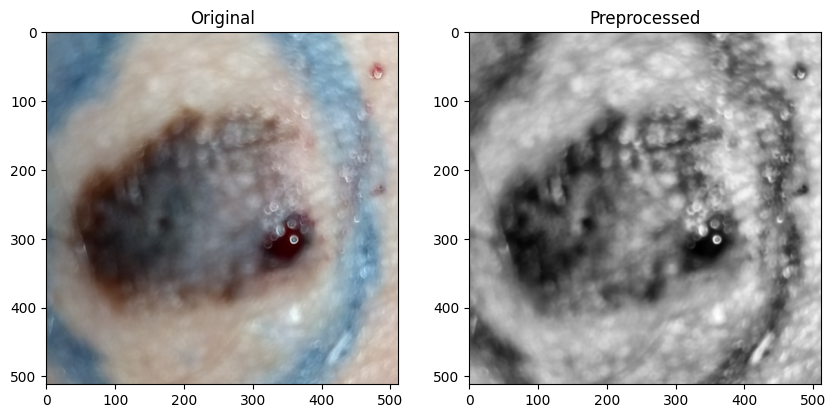

In [61]:
# Call the function to preprocess the image
# image_path = "..\\data\\images_resized\\PAT_70_107_591.png"
image_path = "..\\data\\images_resized\\PAT_70_107_155.png"
preprocessed_image = preprocess_image(image_path)

# Display the original and preprocessed images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
ax[0].set_title("Original")
ax[1].imshow(preprocessed_image, cmap="gray")
ax[1].set_title("Preprocessed")
plt.show()

In [62]:
def preprocess_image_util(input_folder, output_folder):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for file_name in os.listdir(input_folder):
        # Preprocess the image
        image_path = os.path.join(input_folder, file_name)
        preprocessed_image = preprocess_image(image_path)

        # Save the preprocessed image to the output folder
        output_path = os.path.join(output_folder, file_name)
        cv2.imwrite(output_path, preprocessed_image)

In [63]:
input_folder = '..\\data\\images_resized'
output_folder = '..\\data\\images_preprocessed'
preprocess_image_util(input_folder, output_folder)

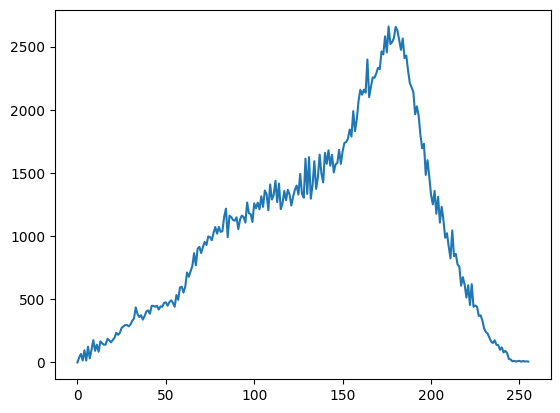

In [64]:
# Image intensity histogram

im_hist = cv2.calcHist([preprocessed_image], [0], None, [256], [0, 256])
plt.plot(im_hist)

In [79]:
def create_mask(img):
    # Check if input image is grayscale or color
    if len(img.shape) == 2:  # Grayscale image
        gray = img
    else:  # Color image
        # Convert the input image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Otsu's thresholding method to obtain a binary image
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Apply morphological operations to clean up the binary image
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15,15))
    opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

    # Apply connected components analysis to obtain the mask
    connectivity = 8
    _, labels, stats, _ = cv2.connectedComponentsWithStats(closing, connectivity, cv2.CV_32S)

    # Get the index of the largest connected component (which should correspond to the lesion)
    largest_component = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1

    # Create a binary mask for the lesion
    mask = np.uint8(labels == largest_component)

    return mask


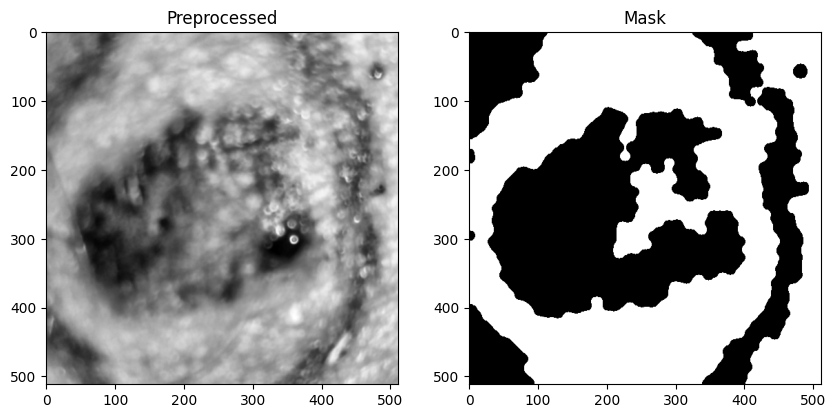

In [80]:
mask = create_mask(preprocessed_image)

# Display the mask side by side with the original image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(preprocessed_image, cmap="gray")
ax[0].set_title("Preprocessed")
ax[1].imshow(mask, cmap="gray")
ax[1].set_title("Mask")
plt.show()

In [81]:
def create_mask_util(input_folder, output_folder):
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    for filename in os.listdir(input_folder):
        # Load image
        img = cv2.imread(os.path.join(input_folder, filename))

        # Create mask
        mask = create_mask(img)

        # Save mask in output folder with same filename as input image
        mask_uint8 = (mask * 255).astype(np.uint8)
        cv2.imwrite(os.path.join(output_folder, filename), mask_uint8)

In [82]:
input_folder = '..\\data\\images_preprocessed'
output_folder = '..\\data\\images_mask_automated'
create_mask_util(input_folder, output_folder)

Create reverse of the mask
This is for making measuring the aymmetry and size of the mask easier

In [85]:
# Define the paths to the two folders
masks_dir = '..\\data\\images_mask_automated'
reverse_mask_output_dir = '..\\data\\images_mask_automated_reversed'

# Create the output folder if it doesn't exist
os.makedirs(reverse_mask_output_dir, exist_ok=True)

# Loop through each mask in the masks folder
for filename in os.listdir(masks_dir):
    # Load the mask image
    mask_path = os.path.join(masks_dir, filename)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Reverse the mask
    mask_reversed = cv2.bitwise_not(mask)

    # Save the reversed mask in the output folder with the same filename
    output_path = os.path.join(reverse_mask_output_dir, filename)
    cv2.imwrite(output_path, mask_reversed)

Access how well the mask is working using dice coefficient:


(1) Properlly binarize mask images in the "../data/shanon_masks_total" folder

In [97]:
def calculate_dice_coefficient(pred_mask, gt_mask):
    # Binarize the masks
    pred_mask = (pred_mask > 127).astype(np.uint8)
    gt_mask = (gt_mask > 127).astype(np.uint8)

    # Flatten the masks
    pred_mask = pred_mask.flatten()
    gt_mask = gt_mask.flatten()

    # Calculate Dice coefficient
    dice_coefficient = f1_score(gt_mask, pred_mask)

    return dice_coefficient

       Mean    Median  Standard Deviation   Minimum   Maximum
0  0.455688  0.410492            0.286341  0.011183  0.976055


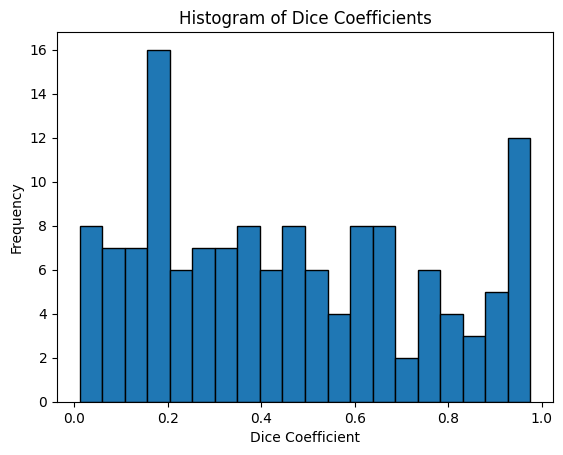

In [99]:
# Paths to the folders
pred_folder = '../data/images_mask_automated_reversed'
gt_folder = '../data/shanon_masks_total'

# Initialize a list to store the Dice coefficients
dice_coefficients = []

# Iterate over all images in the predicted masks folder
for filename in os.listdir(pred_folder):
    # Load the predicted mask and the ground truth mask
    pred_mask_path = os.path.join(pred_folder, filename)
    gt_mask_path = os.path.join(gt_folder, filename)
    pred_mask = cv2.imread(pred_mask_path, cv2.IMREAD_GRAYSCALE)
    gt_mask = cv2.imread(gt_mask_path, cv2.IMREAD_GRAYSCALE)

    # Calculate the Dice coefficient
    dice_coefficient = calculate_dice_coefficient(pred_mask, gt_mask)
    dice_coefficients.append(dice_coefficient)

# Calculate statistics
mean = np.mean(dice_coefficients)
median = np.median(dice_coefficients)
std_dev = np.std(dice_coefficients)
min_val = np.min(dice_coefficients)
max_val = np.max(dice_coefficients)

# Create a DataFrame for pretty printing
stats_df = pd.DataFrame({
    'Mean': [mean],
    'Median': [median],
    'Standard Deviation': [std_dev],
    'Minimum': [min_val],
    'Maximum': [max_val]
})

# Print the DataFrame
print(stats_df)

# Plot a histogram of the Dice coefficients
plt.hist(dice_coefficients, bins=20, edgecolor='black')
plt.title('Histogram of Dice Coefficients')
plt.xlabel('Dice Coefficient')
plt.ylabel('Frequency')
plt.show()

Some representative images and their masks

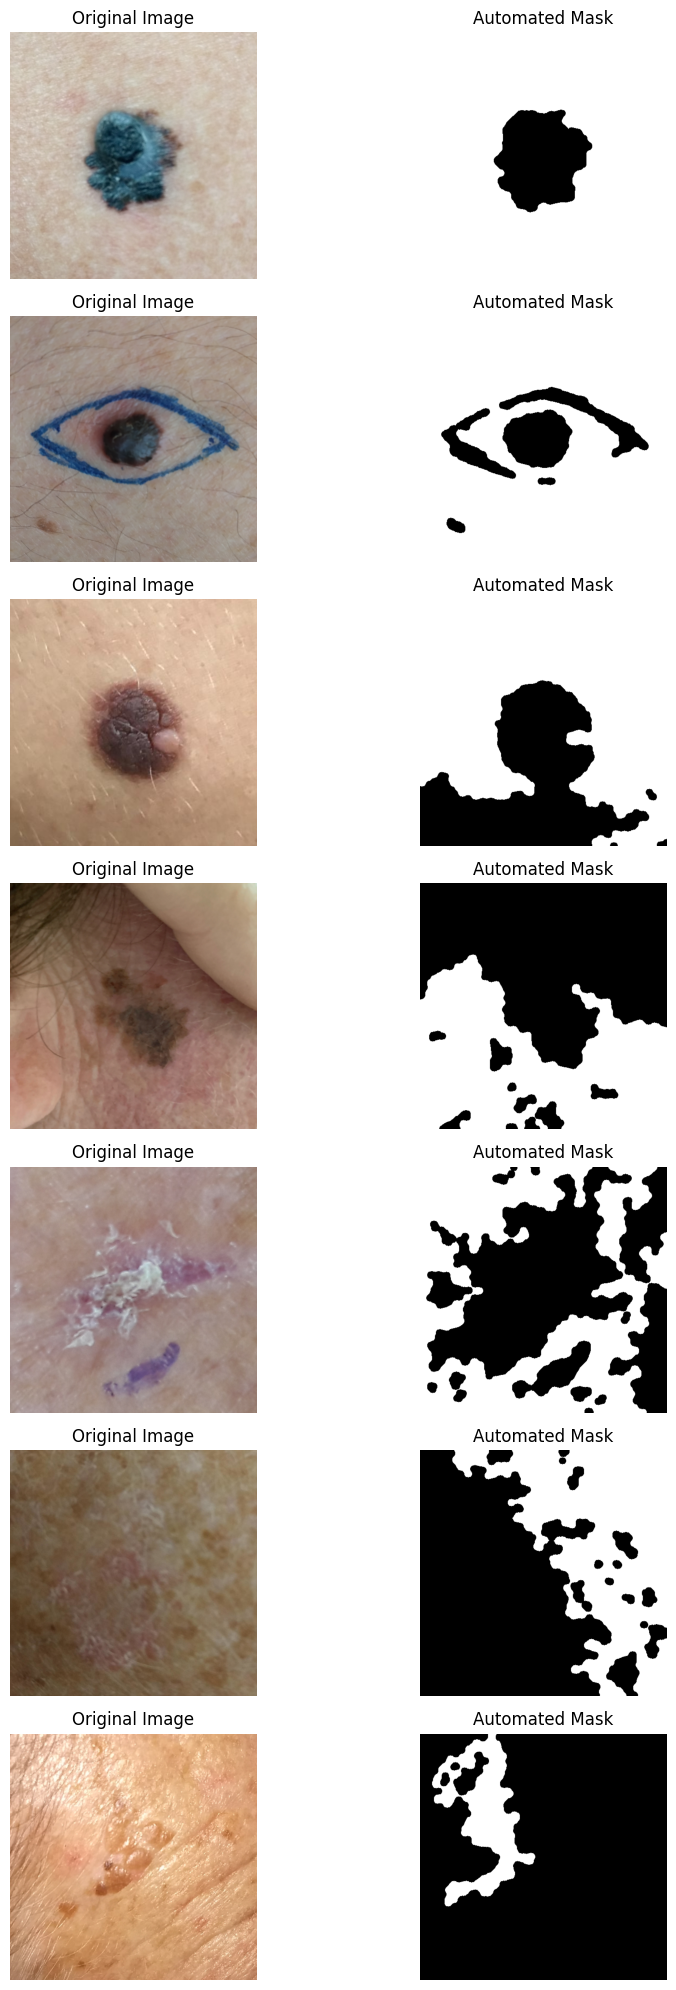

In [15]:
# Set the folders containing the images
folder_left = "..\\data\\images_resized"
folder_right = "..\\data\\images_mask_automated"

# List of specific images to display
image_files = [
    "PAT_340_714_68.png",
    "PAT_894_1679_640.png",
    "PAT_1148_542_708.png",
    "PAT_966_1825_584.png",
    "PAT_2043_4308_681.png",
    "PAT_1670_3007_105.png",
    "PAT_851_4520_743.png"
]

# Set the number of pairs to display
num_pairs = len(image_files)

# Set up the subplots
fig, axes = plt.subplots(num_pairs, 2, figsize=(10, 20))

# Loop through the pairs and display them side by side
for i in range(num_pairs):
    # Load the left and right images
    left_image_path = os.path.join(folder_left, image_files[i])
    right_image_path = os.path.join(folder_right, image_files[i])
    left_image = Image.open(left_image_path)
    right_image = Image.open(right_image_path)
    
    # Display the left and right images side by side
    axes[i, 0].imshow(left_image)
    axes[i, 0].set_title('Original Image')
    axes[i, 0].axis('off')
    axes[i, 1].imshow(right_image, cmap='gray')
    axes[i, 1].set_title('Automated Mask')
    axes[i, 1].axis('off')
    
# Display the plot
plt.tight_layout()
plt.show()
